# Global Ocean Waves Analysis

As a part of the continuous Marine Data support, this time Planet OS Team releases a [Meteo France Global Ocean Waves Analysis](https://data.planetos.com/datasets/meteo_france_global_ocean_wave_analysis_daily) and [Meteo France WAve Model (MFWAM) Global Forecast](https://data.planetos.com/datasets/meteofrance_global_ocean_forecast) to the [Planet OS Datahub](https://data.planetos.com). Coastal communities, businesses, and professionals are relying on the quality of the marine weather predictions. From major weather events like storms or hurricanes down to daily check on what is the best time to go to the beach, reliable marine weather models affect the lives of millions.

The global wave system of Météo-France is based on the wave model MFWAM which is a third generation wave model. MFWAM uses the computing code ECWAM-IFS-38R2 with a dissipation terms developed by Ardhuin et al. (2010). The model MFWAM was upgraded on november 2014 thanks to improvements obtained from the european research project « my wave » (Janssen et al. 2014). The model mean bathymetry is generated by using 2-minute gridded global topography data ETOPO2/NOAA. Native model grid is irregular with decreasing distance in the latitudinal direction close to the poles. At the equator the distance in the latitudinal direction is more or less fixed with grid size 1/10°. The operational model MFWAM is driven by 6-hourly analysis and 3-hourly forecasted winds from the IFS-ECMWF atmospheric system. The wave spectrum is discretized in 24 directions and 30 frequencies starting from 0.035 Hz to 0.58 Hz. The model MFWAM uses the assimilation of altimeters with a time step of 6 hours. The global wave system provides analysis 4 times a day, and a forecast of 5 days at 0:00 UTC. The wave model MFWAM uses the partitioning to split the swell spectrum in primary and secondary swells.

With this release, we hope more app developers and domain experts would jump on board and create value-add applications and extend their customer base in marine navigation, aquaculture, and other related domains. We also hope that businesses could utilize such data in their business analytics to derive valuable insights for operations, planning and risk assessments.

In this Notebook we show how to use wave height data from the analysis. As the [hurricane Dorian](https://blogs.nasa.gov/hurricanes/tag/dorian-2019/) is active at the time of making this notebook, we use it as an example. 

Let's start with the code now. For preventing issues with version incompatibility, we'll print out some most important module versions. Also, make sure you are using python3

In [109]:
import os
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import imageio
import shutil
import datetime
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Avenir Lt Std'
mpl.rcParams.update({'font.size': 25})
print('matplotlib', mpl.__version__)
print ('imageio',imageio.__version__)
print ('xarray',xr.__version__)
print ('numpy',np.__version__)

matplotlib 3.0.3
imageio 2.2.0
xarray 0.10.8
numpy 1.16.4


First we define some functions. `make_imgs` function makes images for animation and `make_anim` makes animation using images the first function made.

In [167]:
def make_imgs(dd, lonmap,latmap, variable, vmin,vmax,folder,title):
    vmin = vmin; vmax = vmax
    for k in range(0,len(dd[variable])):
        filename = folder + 'ani_' + str(k).rjust(3,'0') + '.png'
        
        fig = plt.figure(figsize = (14,12))
        ax = fig.add_subplot(111)
        pcm = m.pcolormesh(lonmap,latmap,dd[variable][k].data,vmin = vmin, vmax = vmax,cmap='rainbow')
        levs = np.arange(1,7,1)
        S1 = m.contour(lonmap,latmap,dd[variable][k].data,levs,colors='black',linewidths=0.4,alpha = 0.6)
        plt.clabel(S1,inline=1,inline_spacing=0,fontsize=7,fmt='%1.0f',colors='black')
        m.fillcontinents(color='#58606F')
        m.drawcoastlines(color='#222933')
        m.drawcountries(color='#222933')
        m.drawstates(color='#222933')
        cbar = plt.colorbar(pcm,fraction=0.035, pad=0.03)
        ttl = plt.title(title + '\n ' + str(dd[variable].time[k].data)[:-10],fontweight = 'bold')
        ttl.set_position([.5, 1.05])
        if not os.path.exists(folder):
            os.mkdir(folder)
        plt.savefig(filename)
        if k == 10:
            plt.show()
        plt.close()
def make_anim(folder,anim_name):
    files = sorted(os.listdir(folder))
    fileList = []
    for file in files:
        if not file.startswith('.'):
            complete_path = folder + file
            fileList.append(complete_path)
    
    writer = imageio.get_writer(anim_name, fps=4)
    
    for im in fileList:
        writer.append_data(imageio.imread(im))
    writer.close()
    print ('Animation is saved as ' + anim_name + ' under current working directory')
    shutil.rmtree(folder)

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/

In [111]:
API_key = open('APIKEY').read().strip()
server='api.planetos.com/'
version = 'v1'

Here we define dataset Global Ocean wave analysis dataset namespace, variable names, period start and end, location and name of the animation that will be saved into your computer. We choose a time period when [hurricane Dorian](https://blogs.nasa.gov/hurricanes/tag/dorian-2019/) were active near Bahamas. First we use variables `VHM0_SW1` and `VMDR_SW1` which are Spectral significant primary swell wave height. You can find more variables from the [dataset detail page](https://data.planetos.com/datasets/cmems_global_ocean_wave_analysis_daily). 

'2019-09-06T00:00:00'

In [166]:
time_start = '2019-08-30T00:00:00'
time_end = str(datetime.datetime.today().strftime('%Y-%m-%d') + 'T00:00:00')#'2019-09-06T00:00:00'
dataset_key = 'meteo_france_global_ocean_wave_analysis_daily'
variable1 = 'VHM0_SW1'
area = 'bah'
latitude_north = 40;  latitude_south = 12
longitude_west = -89; longitude_east = -58
anim_name = variable1 + '_animation_' + str(datetime.datetime.strptime(time_start,'%Y-%m-%dT%H:%M:%S').year) + '.mp4'

In the following cell we are downloading the data. 

In [113]:
dh=datahub.datahub(server,version,API_key)
package = package_api.package_api(dh,dataset_key,variable1,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area+variable1)
package.make_package()
package.download_package()

Package exists
File already downloaded


Now we open the file by using xarray.

In [114]:
dd1 = xr.open_dataset(package.local_file_name)

We like to use Basemap to plot data on it. Here we define the area. You can find more information and documentation about [Basemap here](https://matplotlib.org/basemap/). 
Also, we make local folder where we save images. These are the images we will use for animation. No worries, in the end, we will delete the folder from your system.

In [115]:
dd1['longitude'] = ((dd1.longitude+180) % 360) - 180
m = Basemap(projection='merc', lat_0 = 0, lon_0 =  (longitude_east + longitude_west)/2,
         resolution = 'l', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)

lons,lats = np.meshgrid(dd1.longitude,dd1.latitude)
lonmap,latmap = m(lons,lats)

folder = './ani/'
if not os.path.exists(folder):
    os.mkdir(folder)

Now it is time to make images from every time step. We only show one time step here. 
To better understand the images, it is important to know what exactly Significant Primary Swell Wave height is. One way to understand swell waves is to read [our blogpost about it](https://medium.com/planet-os/understanding-surf-forecasts-the-story-behind-swell-waves-280d3ec1a569). However, we will do a brief explanation here as well. 

[The Bureau of Meteorology](http://www.bom.gov.au/marine/knowledge-centre/reference/waves.shtml) provides a good explanation about different waves. 
Wave heights describe the average height of the highest third of the waves (defined as the significant wave height). It is measured by the height difference between the wave crest and the preceding wave trough. Swell waves are the regular, longer period waves generated by distant weather systems. They may travel over thousands of kilometres. There may be several sets of swell waves travelling in different directions, causing crossing swells and a confused sea state. Crossing swells may make boat handling more difficult and pose heightened risk on ocean bars. There may be swell present even if the wind is calm and there are no sea waves. 
Most of the models use energy-based wave identification: They output a primary and secondary swell to refer to the height and direction of the swell with the highest (and second highest) energy component.

In the first animation we show significant primary swell wave height. But in the second animation we show Significan wave height. It is the combined height of the sea and the swell that mariners experience on open water. So, the first one only show primary swell height, while the second animation is combine height of the sea and swell.  

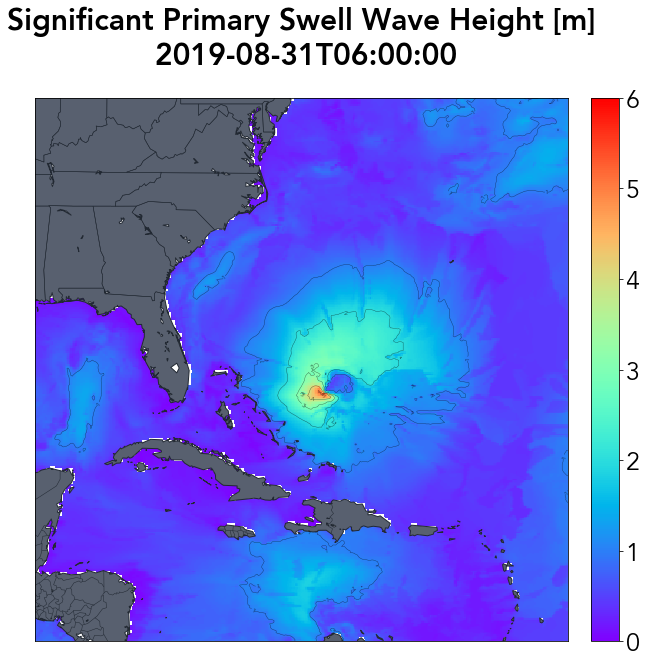

In [116]:
title = 'Significant Primary Swell Wave Height [m]'
vmin = 0; vmax = 6
make_imgs(dd1, lonmap,latmap, variable1, vmin,vmax,folder,title)

This is part where we are making animation. 

In [117]:
make_anim(folder, anim_name)

Animation is saved as VHM0_SW1_animation_2019.mp4 under current working directory


Now we download Significant Wave Height data to see the difference in images. 

In [118]:
variable2 = 'VHM0'
anim_name2 = variable2 + '_animation_' + str(datetime.datetime.strptime(time_start,'%Y-%m-%dT%H:%M:%S').year) + '.mp4'
package2 = package_api.package_api(dh,dataset_key,variable2,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area + variable2)
package2.make_package()
package2.download_package()

Package exists
File already downloaded


As explained above, significant wave height is the combined height of the sea and the swell waves. We can see that hurricane is seen much more round and higher height. The reason is that here, wind and swell wave are both taken into account. In the image above, only primary swell waves were shown. 

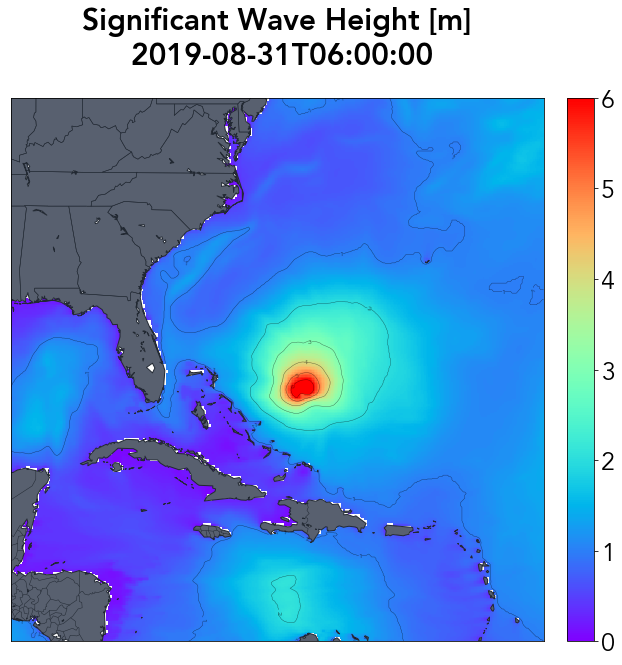

In [119]:
dd2 = xr.open_dataset(package2.local_file_name)
title = 'Significant Wave Height [m]'
vmin = 0; vmax = 6
make_imgs(dd2, lonmap,latmap, variable2, vmin,vmax,folder,title)

In [120]:
make_anim(folder, anim_name2)

Animation is saved as VHM0_animation_2019.mp4 under current working directory


We have seen the historic data about waves, but let's see what the future brings now. For that we use data from [Meteo France WAve Model (MFWAM) Global Forecast](https://data.planetos.com/datasets/meteofrance_global_ocean_forecast). It is using the same model as the analysis.

In [127]:
dataset_key2 = 'meteofrance_global_ocean_forecast'
reftime_start = str(datetime.datetime.today().strftime('%Y-%m-%d') + 'T00:00:00')#'2019-09-06T00:00:00'
reftime_end = str(datetime.datetime.today().strftime('%Y-%m-%d') + 'T00:00:00')#'2019-09-06T00:00:00'
package3 = package_api.package_api(dh,dataset_key2,variable2,longitude_west,longitude_east,latitude_south,latitude_north,reftime_start=reftime_start,reftime_end=reftime_end,area_name=area+variable2)
package3.make_package()
package3.download_package()

http://api.planetos.com//v1/packages?apikey=8428878e4b944abeb84790e832c633fc&dataset=meteofrance_global_ocean_forecast&package=meteofrance_global_ocean_forecast_recent_reftime_20190906_bahVHM0&var=VHM0&z=all&polygon=%5B%5B-89%2C+12%5D%2C+%5B-58%2C+12%5D%2C+%5B-58%2C+40%5D%2C+%5B-89%2C+40%5D%2C+%5B-89%2C+12%5D%5D&reftime_recent=false&reftime_start=2019-09-06T00%3A00%3A00&reftime_end=2019-09-06T00%3A00%3A00


In [136]:
dd3 = xr.open_dataset(package3.local_file_name)
dd3 = dd3.drop('reftime')

We merge analysis and forecast datasets by using xarray concat. It merges two datasets by 'time' dimension and if there's some data conflict, it uses dd2 (analysis) data as it is more precise than forecast. 

In [158]:
dd_merged = xr.concat([dd2,dd3],dim='time')

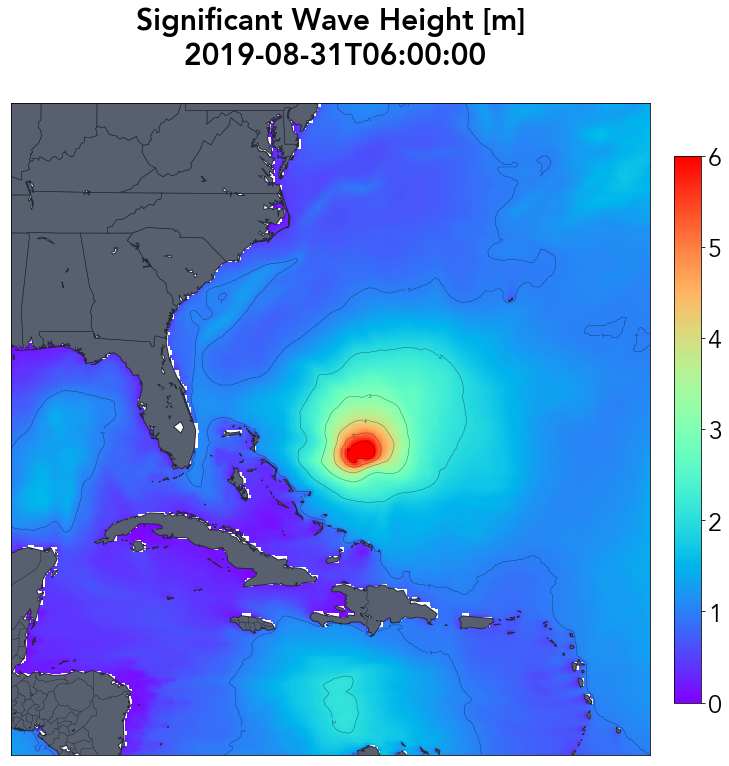

In [168]:
title = 'Significant Wave Height [m]'
anim_name3 = variable2 + '_animation_forecast_analysis_' + str(datetime.datetime.strptime(time_start,'%Y-%m-%dT%H:%M:%S').year) + '.mp4'
vmin = 0; vmax = 6
make_imgs(dd_merged, lonmap,latmap, variable2, vmin,vmax,folder,title)

In [169]:
make_anim(folder, anim_name3)

Animation is saved as VHM0_animation_forecast_analysis_2019.mp4 under current working directory


In this notebook we can learnt how to download data from Planet OS Datahub by using package API. Also, got some knowledge of waves and saw how difference between significant wave height and primary swell wave height. We also merged two datasets - analysis and forecast - to get animation that covers history and forecast combined. We also got two interesting animations about wave heights during hurricane Dorian.  